In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt

import tensorflow as tf
print(tf. __version__)

2.10.0


## Load model

In [2]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
from RMSA import RMSA
q_rs = (np.arange(80)+1)*0.2
def SQ_RMSA(parameters):
    return (RMSA(q_rs, 0.5, scl=parameters[1], gamma=parameters[2], eta=parameters[0]))[1]

## Define functions

In [3]:
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out

def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def IQ_th(sq_func,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp

## Load data

In [4]:
# Training set
parameters_zscore = 0
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


### resolution

In [5]:
# from scipy.io import loadmat
# filename_EQSANS = './EQSANS.mat'
# loaded_EQSANS = loadmat(filename_EQSANS)
# q_EQSANS_0 = loaded_EQSANS['Q_real'][:,0]#.astype('float32')
# qsig_EQSANS = loaded_EQSANS['qsig'][:,0]#.astype('float32')
# data = loaded_EQSANS['data']#.astype('float32')
# qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
# q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
# qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

data_EQSANS = np.loadtxt('./EQSANS.txt',delimiter=',',skiprows=2)
q_EQSANS_0 = data_EQSANS[:,0]#.astype('float32')
qsig_EQSANS = data_EQSANS[:,3]#.astype('float32')
IQ_EQSANS = data_EQSANS[:,1]#.astype('float32')
E_EQSANS = data_EQSANS[:,2]#.astype('float32')

qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)

## Select data and produce I(Q)

In [6]:
print('\neta in')
print(np.unique(eta))
print('\nkappa in')
print(np.unique(kappa))
print('\nA in')
print(np.unique(A))


eta in
[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]

kappa in
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]

A in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


In [7]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(eta-parameters[0])<tol
    id_kappa = np.abs(kappa-parameters[1])<tol
    id_A = np.abs(A-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

In [8]:
# potential_list = np.array([[0.3,5.0],[0.5,10.0],[0.3,20.0]])
# eta_list = np.array([0.015,0.105,0.3])

# parameters = np.r_[eta_list[1],potential_list[1]]
parameters = np.array([0.105, 0.5, 10.0])
fp_GT = np.r_[parameters,np.array([1,1,0.01])]

SQ_exp_GT = sq_rs[id_params(parameters),:][0]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

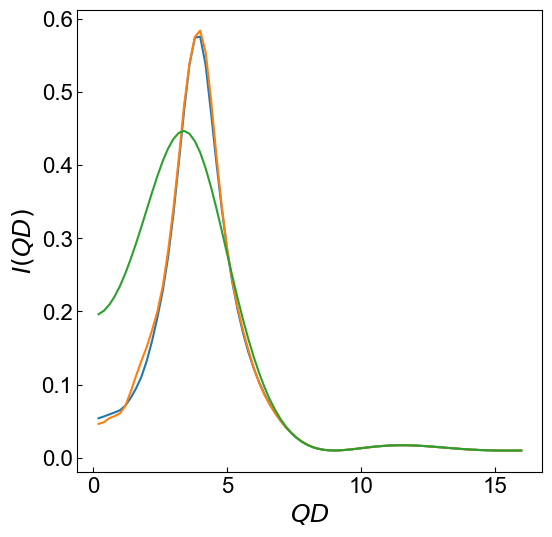

In [9]:
def IQ_exp(sq_GT,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = sq_GT

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)

    IQ_exp = f_interp(q_rs)
    return IQ_exp

IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)
IQ_exp_NN = IQ_th(SQ_NN,fp_GT)
IQ_exp_RMSA = IQ_th(SQ_RMSA,fp_GT)

fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

ax.plot(q,IQ_exp_GT)
ax.plot(q,IQ_exp_NN)
ax.plot(q,IQ_exp_RMSA)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

## Fit

In [10]:
tol = 1e-12
def Fit_loss(sq_func,fp):
#     return ((IQ_exp_GT)-(IQ_th(sq_func,fp)))[(q>=0)&(q<=16)]
    return (np.log(IQ_exp_GT+tol)-np.log(IQ_th(sq_func,fp)+tol))[(q>=0)&(q<=16)]
#     return (sm_GP((IQ_exp_GT)-(IQ_th(sq_func,fp)),lmbda=0.1,sigma=0.01))[(q>=0)&(q<=16)]

In [11]:
'''
Fitting parameters:
fp = [eta, kappa, A, sigma, C, I_inc]

I(Q) = C*P(Q)*S(Q) + I_inc
sigma: scaling parameter
'''

fp_i =       [0.2,  0.35,   6,  1.0,  1.0,  0.01]
fp_lbounds = (0.015, 0.02,   1,   0.1, 0.1,  0.001)
fp_ubounds = (0.5,   0.5,   100,  2.0, 2.0,  0.1)
fp_bounds = [fp_lbounds,fp_ubounds]
fp_bounds_opt = opt.Bounds(lb=np.array(fp_lbounds), ub=np.array(fp_ubounds))

fp_i = np.random.uniform(low=fp_lbounds, high=fp_ubounds)

In [12]:
fp_i

array([4.48627304e-01, 4.57899671e-01, 6.53369114e+01, 1.72552868e+00,
       2.40808066e-01, 1.24406492e-02])

In [13]:
SQ_NN_GP = lambda x: SQ_NN(x,GP=True,lmbda=0.2)
Fit_loss_NN = lambda x: Fit_loss(SQ_NN,x)
Fit_loss_RMSA = lambda x: Fit_loss(SQ_RMSA,x)

def func_IQ_NN_err(fp):
    return np.mean((Fit_loss(SQ_NN,fp))**2)
def func_IQ_RMSA_err(fp):
    return np.mean((Fit_loss(SQ_RMSA,fp))**2)

def func_minimize(func, fp_fix, fp_x0, index_x):
    index_fixed = np.array([x for x in np.arange(len(fp_fix)) if not x in index_x])

    def f(x,args):
        fp = fp_fix
        for i, index in enumerate(index_x):
            fp[index] = x[i]
        return func(fp)

    x_bounds = opt.Bounds(lb=np.array(fp_lbounds)[index_x], ub=np.array(fp_ubounds)[index_x])

    if len(index_fixed)==0:
        args_fixed = None
    else:
        args_fixed = fp_fix[index_fixed]

    opti = opt.minimize(f, x0=np.array(fp_x0)[index_x], args=args_fixed, 
                        method='L-BFGS-B',bounds=x_bounds,
                        jac='3-point',
#                         options={'maxiter':1000,'ftol':1e-16, 'gtol':1e-16},
                        )
    return opti

In [14]:
index_free=[0,1,2,4]
opti_NN = func_minimize(func_IQ_NN_err, fp_fix=fp_GT.copy(), fp_x0=fp_i.copy(), index_x=index_free)
opti_RMSA = func_minimize(func_IQ_RMSA_err, fp_fix=fp_GT.copy(), fp_x0=fp_i.copy(), index_x=index_free)

fp_opt_NN = fp_GT.copy()
for i, index in enumerate(index_free):
    fp_opt_NN[index] = opti_NN.x[i]
    
fp_opt_RMSA = fp_GT.copy()
for i, index in enumerate(index_free):
    fp_opt_RMSA[index] = opti_RMSA.x[i]

In [15]:
opti_NN

      fun: 0.00023639893406141718
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.96697835e-03, -6.98867239e-04,  1.08361535e-05,  7.02375607e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 819
      nit: 60
     njev: 91
   status: 0
  success: True
        x: array([ 0.10294391,  0.4113461 , 11.09582905,  0.98974745])

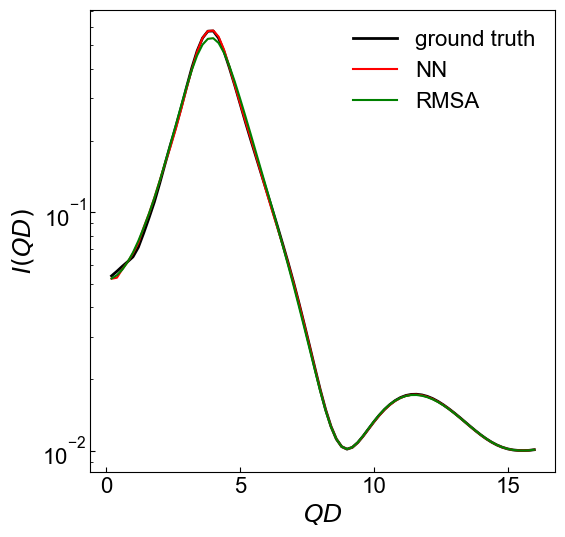

In [16]:
fig = plt.figure(figsize=(6, 6))#,dpi=192)
ax = plt.subplot(1, 1, 1)

ax.plot(q,IQ_exp_GT,'-k',lw=2,
        label='ground truth')
ax.plot(q,IQ_th(SQ_NN,fp_opt_NN),'-r',
        label='NN')
ax.plot(q,IQ_th(SQ_RMSA,fp_opt_RMSA),'-g',
        label='RMSA')

ax.set_yscale('log')
ax.legend(fontsize=16,frameon=False,fancybox=False)

ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=16)

plt.show()

In [17]:
#relative error
fp_NN_err = (fp_opt_NN-fp_GT)/fp_GT
fp_NN_RMSA = (fp_opt_RMSA-fp_GT)/fp_GT

In [18]:
print('Fitting Parameters')
print('eta     kappa   A    sigma   C     I_inc\n')
print('Ground Truth')
print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}\n'.format(*fp_GT))
print('SQ_NN')
print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_NN))
print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n'.format(*fp_NN_err*100))
print('SQ_RMSA')
print('{:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}  {:0.4f}'.format(*fp_opt_RMSA))
print('{:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%  {:2.2f}%\n'.format(*fp_NN_RMSA*100))

Fitting Parameters
eta     kappa   A    sigma   C     I_inc

Ground Truth
0.1050  0.5000  10.0000  1.0000  1.0000  0.0100

SQ_NN
0.1029  0.4113  11.0958  1.0000  0.9897  0.0100
-1.96%  -17.73%  10.96%  0.00%  -1.03%  0.00%

SQ_RMSA
0.1064  0.5000  65.3363  1.0000  0.9956  0.0100
1.29%  0.00%  553.36%  0.00%  -0.44%  0.00%



In [19]:
# def func_IQ_NN(q,eta,kappa,A,sigma,C,I_inc):
#     return IQ_th(SQ_NN,[eta,kappa,A,sigma,C,I_inc])
# def func_IQ_RMSA(q,eta,kappa,A,sigma,C,I_inc):
#     return IQ_th(SQ_RMSA,[eta,kappa,A,sigma,C,I_inc])

# fp_opt_NN, fpcov_NN = opt.curve_fit(func_IQ_NN, q, IQ_exp_GT, p0=fp_i)
# fp_opt_RMSA, fpcov_RMSA = opt.curve_fit(func_IQ_RMSA, q, IQ_exp_GT, p0=fp_i)

# opti_NN = opt.least_squares(Fit_loss_NN,
#                             fp_i,bounds=fp_bounds, 
#                             xtol = 1e-15, ftol = 1e-15,
#                             x_scale='jac')
# opti_RMSA = opt.least_squares(Fit_loss_RMSA,
#                               fp_i,bounds=fp_bounds, 
#                               xtol = 1e-15, ftol = 1e-15,
#                               x_scale='jac')

In [20]:
# opti_NN = opt.minimize(func_IQ_NN_err, fp_i, 
#                        method='L-BFGS-B',bounds=fp_bounds_opt,
#                        jac='3-point',
#                        options={'ftol':1e-16, 'gtol':1e-16},
#                       )
# opti_RMSA = opt.minimize(func_IQ_RMSA_err, fp_i, 
#                          method='L-BFGS-B',bounds=fp_bounds_opt,
#                          jac='3-point',
# #                          options={'ftol':1e-16, 'gtol':1e-16},
#                         )



# fp_opt_NN = opti_NN.x
# fp_opt_RMSA = opti_RMSA.x